## Causal Inference on the average treatment effect (ATE) of quitting smoking ($T$) on weight gain ($Y$)

### Student: Mengyao Zheng




I have performed a causal analysis on a real-world healthcare dataset, known as the *NHANES I Epidemiologic Follow-up Study (NHEFS)* dataset. It is a government-initiated longitudinal study designed to investigate the relationships between clinical, nutritional, and behavioral factors. For more detail, please see [here](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/).

The task is to estimate the average treatment effect (ATE) of quitting smoking ($T$) on weight gain ($Y$). The NHEFS cohort includes 1,566 cigarette smokers between 25 - 74 years of age who completed two medical examinations at separate time points: a baseline visit and a follow-up visit approximately 10 years later. Individuals were identified as the treatment group if they reported smoking cessation before the follow-up visit. Otherwise, they were assigned to the control group. Finally, each individual’s weight gain, $Y$, is the difference in *kg* between their body weight at the follow-up visit and their body weight at the baseline visit. 

The notebook includes the following parts:
1. how a mechanism of how confounders, when unadjusted, can introduce bias into the ATE estimate. 
2. Implement propensity score re-weighting to estimate the ATE in Python.
3. Implement covariate adjustment strategies to estimate the conditional average treatment effect (CATE) as well as ATE in Python.
4. Assess how robust the ATE estimate is against potential unobserved confounders via sensitivity analysis. 

In [1]:
# import packages and load the data
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import scipy.stats

from collections import OrderedDict
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import auth
import math

In [2]:
# load the nfefs data
nhefs_all = pd.read_csv('https://github.com/mlhcmit/psets/blob/master/2022/pset4/nhefs.csv?raw=true')

outcome_col = [
    'wt82_71' # weight gain measured after 10 years from the baseline. 
]

treatment_col = [
    'qsmk' # indicator for smoking cessation 
]

# drop samples with missing outcomes for the assignment
# note that this could introduce selection bias and a proper analysis should account for the censored samples. 
missing = nhefs_all[outcome_col].isnull().any(axis=1)
nhefs = nhefs_all.loc[~missing]

Let $Y$ denote an outcome of interest and $T \in \{0, 1\}$ denote a binary treatment. Furthermore, let $Y(t)$ denote the potential outcome of an individual under treatment, $T = t$. In randomized experiments, we learned that the average treatment effect (ATE) is, 

\begin{align}
  E[Y(1) - Y(0)] = E[Y|T = 1] - E[Y|T=0],
\end{align} 

given that the treatment $T$ is well-defined. In other words, in randomized experiments where a treatment is randomly assigned, association is *causation*. However, since we are dealing with observatonal data, we cannot conclude that association is causation. As we learned in the lecture, we will need additional assumptions and adjustment strategies, which you will get a chance to utilize throughout this problem set. 

We will first start with computing the mean difference in outcome between the treatment (quitters; $T = 1$) and control groups (non-quitters; $T = 0$), without any adjustment for potential confounders. 

In [3]:
##############################################################################
#                                                                            #
# Compute mean difference in outcomes between treatment (quitters) and       #
# control groups (non-quitters). In other words, E[Y|T=1] - E[Y|T=0].        #
#                                                                            #
##############################################################################

nhefs_quit = nhefs[nhefs.qsmk == 1]
nhefs_noquit = nhefs[nhefs.qsmk == 0]

nhefs_quit[outcome_col].mean().values - nhefs_noquit[outcome_col].mean().values

array([2.54058145])

As we discussed before, in our observational data, a treatment (i.e. quit smoking) is not randomly assigned, and it is very likely dependent on individual characteristics. For example, we can reasonably assume that a proclivity for alcohol and exercise habits may influence one’s decision to quit smoking (i.e. treatment) as well as weight gain (i.e. outcome). Therefore, if we fail to adjust for these factors (i.e. confounders), we may introduce bias in our causal estimate. 


# Synthetic example: analyzing bias
In this section, we will provide a scenario where the outcome, $Y$, is a simple quadratic function of a single confounding covariate, $X$. You will analyze the size of the bias when failing to adjust for this confounder $X$. Now, suppose that $\theta$ is the true treatment effect that we are interested in and that the outcome $Y$ and sole confounder $X$ are related as follows: 

\begin{align}
  Y = \beta_0 + \beta_1 X + \beta_2 X^2 + \theta T,
\end{align}

where $T$ again denotes the treatment.


#
Then we can derice the bias in the estimated treatment effect (i.e. $\theta - \hat{\theta}$) if we fail to adjust for $X$. (*hint* : use the formula $E[Y(1) - Y(0)] = E[Y|T = 1] - E[Y|T=0]$ to obtain $\hat{\theta}$.


$\hat{\theta} = E(Y | T = 1) - E(Y | T = 0) = E(\beta_0 + \beta_1X + \beta_2X^2  + θ | T = 1) - (\beta_0 + \beta_1X + \beta_2X^2  + θ | T = 0) = \beta_1(E(X|T = 1) - E(X|T = 0)) + \beta_2(E(X^2|T = 1) - E(X^2|T = 0)) + θ $

Thus,

$θ - \hat{θ} = - \beta_1(E(X|T = 1) - E(X|T = 0)) - \beta_2(E(X^2|T = 1) - E(X^2|T = 0)) $




Based on the above bias effect equation, which includes of both the sum of the difference between first and second order moments across treatment and control group scaled by $\beta_1$ and $\beta_2$ respectively , we will see non-zero bias as long as $\beta_1$ and $\beta_2$ is non-zero if there were difference.

# Real-world example with NHFES data 

We have seen one simple example of why we should adjust for confounders in order to estimate the ATE in an unbiased way. In this section, we will use the NHFES dataset to do a simple exploratory analysis on the provided set of confounders and investigate important assumptions we have to make, including overlap (i.e. common support; $0 < P(T = t|X = x) < 1,~\forall t, x$), before adjusting for the set of confounders. Note that throughout the analysis, we'll assume ignorability (i.e. $(Y(0), Y(1)) \perp \! \!\! \! \perp T | X$) unless mentioned otherwise.



In [4]:
"""
Provided set of confounders and explanations: 
sex - 0: MALE 1: FEMALE
age - age in 1971
race - 0: WHITE 1: BLACK OR OTHER IN 1971
ht - HEIGHT IN CENTIMETERS IN 1971
education - AMOUNT OF EDUCATION BY 1971: 1: 8TH GRADE OR LESS, 2: HS DROPOUT, 3: HS, 4:COLLEGE DROPOUT, 5: COLLEGE OR MORE
alcoholpy - HAVE YOU HAD 1 DRINK PAST YEAR? IN 1971,  1:EVER, 0:NEVER; 2:MISSING
smokeintensity - NUMBER OF CIGARETTES SMOKED PER DAY IN 1971
smokeyrs - YEARS OF SMOKING
exercise - IN RECREATION, HOW MUCH EXERCISE? IN 1971, 0:much exercise, 1:moderate exercise, 2:little or no exercise
"""

confounders_cols = [
    'sex', 'age', 'race', 'ht', 'education', 'alcoholpy', 'smokeintensity', 'smokeyrs', 'wt71', 'exercise'
]

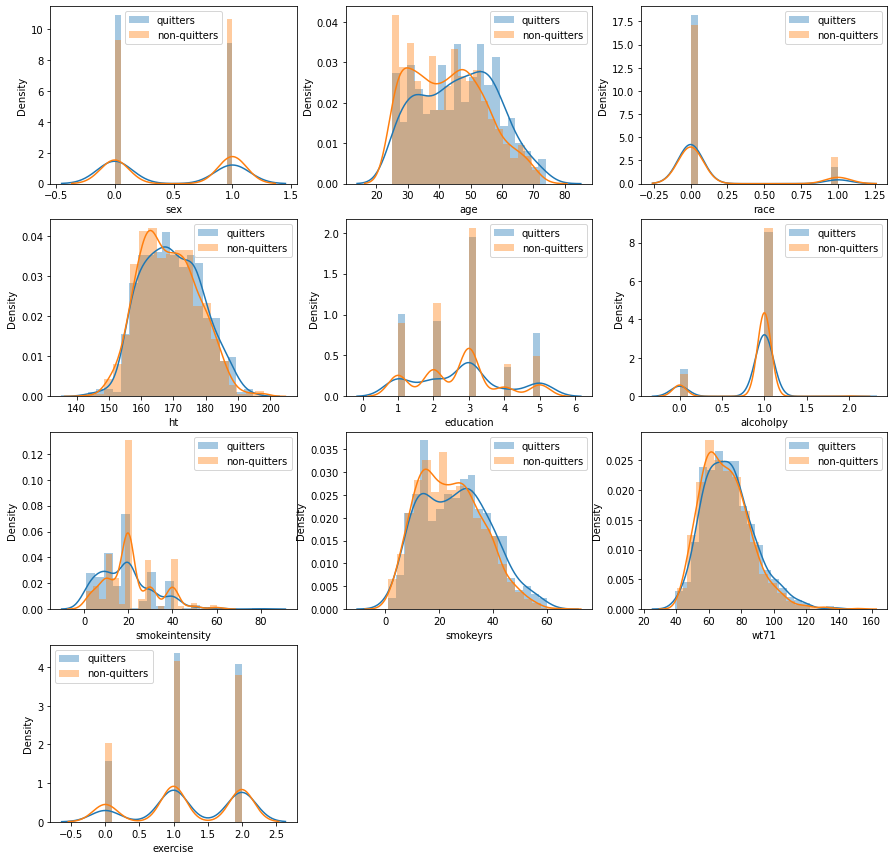

In [5]:
"""
Visualize distribution differences of confounders across treatment and control groups. 
"""
warnings.filterwarnings('ignore')
nhefs_quit = nhefs[nhefs.qsmk == 1]
nhefs_noquit = nhefs[nhefs.qsmk == 0]

plt.figure(figsize=(15,15))
num_bins = 20
for idx, feat in enumerate(confounders_cols):
  plt.subplot(4,3,idx + 1)
  sns.distplot(nhefs_quit[feat], label = 'quitters', bins = num_bins)
  sns.distplot(nhefs_noquit[feat], label = 'non-quitters', bins = num_bins)
  plt.legend()
plt.show()

In [6]:
"""
Create summary table
"""

nhefs['university'] = (nhefs.education == 5).astype('int')
nhefs['inactive'] = (nhefs.active == 2).astype('int')
nhefs['no_exercise'] = (nhefs.exercise == 2).astype('int')

summaries = OrderedDict((
    ('sex', lambda x: (100 * (x == 0)).mean()),
    ('age', 'mean'),
    ('race', lambda x: (100 * (x == 0)).mean()),
    ('ht', 'mean'),
    ('university', lambda x: 100 * x.mean()),
    ('alcoholpy', lambda x: (100 * (x == 1)).mean()),
    ('smokeintensity', 'mean'),
    ('smokeyrs', 'mean'),
    ('wt71', 'mean'),
    ('no_exercise', lambda x: 100 * x.mean()),
))

table = nhefs.groupby('qsmk').agg(summaries)
table.sort_index(ascending=False, inplace=True)
table = table.T

table.index = [
    'Men, %',
    'Age, years',
    'White, %',
    'Height at the baseline, cm',
    'University education, %',
    'Drinks alcohol, %',
    'Cigarettes/day',
    'Years smoking',
    'Weight at the baseline, kg',
    'Little or no exercise, %',
]

# add confidence interval
table_with_ci = pd.DataFrame([], index = table.index, columns = ['treatment (qsmk = 1)', 'control (qsmk = 0)'])
for idx, col_name in zip(table.index, confounders_cols):
  if '%' in idx:
    # treat group
    p_hat = table.at[idx, 1]/100
    se_treat = math.sqrt(p_hat*(1-p_hat)/len(nhefs_quit))*100
    lower_95_ci = table.at[idx, 1] - 1.96*se_treat; upper_95_ci = table.at[idx, 1] + 1.96*se_treat;
    table_with_ci.at[idx, 'treatment (qsmk = 1)'] = '{0:>0.1f} - {1:>0.1f}'.format(lower_95_ci, upper_95_ci)
    # control group
    p_hat = table.at[idx, 0]/100
    se_control = math.sqrt(p_hat*(1-p_hat)/len(nhefs_noquit))*100
    lower_95_ci = table.at[idx, 0] - 1.96*se_treat; upper_95_ci = table.at[idx, 0] + 1.96*se_treat;
    table_with_ci.at[idx, 'control (qsmk = 0)'] = '{0:>0.1f} - {1:>0.1f}'.format(lower_95_ci, upper_95_ci)
  else:
    # treat group
    std = nhefs_quit[col_name].std()
    se_treat = std/math.sqrt(len(nhefs_quit))
    lower_95_ci = table.at[idx, 1] - 1.96*se_treat; upper_95_ci = table.at[idx, 1] + 1.96*se_treat;
    table_with_ci.at[idx, 'treatment (qsmk = 1)'] = '{0:>0.1f} - {1:>0.1f}'.format(lower_95_ci, upper_95_ci)
    # control group
    std = nhefs_noquit[col_name].std()
    se_control = std/math.sqrt(len(nhefs_noquit))
    lower_95_ci = table.at[idx, 0] - 1.96*se_treat; upper_95_ci = table.at[idx, 0] + 1.96*se_treat;
    table_with_ci.at[idx, 'control (qsmk = 0)'] = '{0:>0.1f} - {1:>0.1f}'.format(lower_95_ci, upper_95_ci)
    
print('95% confidence intervals are shown')
table_with_ci

95% confidence intervals are shown


,treatment (qsmk = 1),control (qsmk = 0)
"Men, %",49.7 - 59.5,41.7 - 51.5
"Age, years",45.0 - 47.4,41.6 - 44.0
"White, %",88.3 - 93.9,82.6 - 88.2
"Height at the baseline, cm",168.6 - 170.4,167.6 - 169.3
"University education, %",11.9 - 18.9,6.4 - 13.4
"Drinks alcohol, %",82.2 - 89.0,84.4 - 91.2
Cigarettes/day,17.4 - 19.8,20.0 - 22.4
Years smoking,24.8 - 27.3,22.8 - 25.3
"Weight at the baseline, kg",70.8 - 73.9,68.8 - 71.8
"Little or no exercise, %",35.9 - 45.5,33.1 - 42.7


#### Qualitative analysis :


Based on some common sense, there are some confounders. For example, I think Exercise is a valid confounder, because people usually lose weight after doing extensive exercise. Also, people who exercise regularly are prone to a healthier living habit, thus have a higher chance to quit smoke. Education level can also be a confounder as people who are more ducated are usually more likely to have a balanced weight, and also more likely to quit smoking. Height in my opinion is not a valid confounder. Although being higher is associted with having a higher weight, there is no clear evidence that people who are higher are more or less likely to quite smoke.


Based on the above plot, for many features, although most area in the middle are covered by both treament and control group, some values at the edge(for example, when smokeyrs > 60), there appears to be no overlap, and thus the assumption is not satisfied.



### Propensity Score Re-weighting

We have seen how failing to adjust for the set of confounders can introduce bias in our causal estimate. As we learned in class, propensity score reweighting is one of the most widely used adjustment methods for causal inference. Given that the ignorability and overlap assumptions are satisfied and that our propensity prediction model is correctly specified, scaling each outcome by the inverse of the corresponding propensity score creates a pseudo-population where the treatment assignment is effectively random. More formally, our estimated ATE, $\hat{\theta}$, is derived as follows:

\begin{align}
\hat{\theta} = \frac{1}{N}\sum_{i ~\text{s.t.}~ t_i = 1}\frac{y_i}{\hat{P}(T = 1|X = x_i)} - \frac{1}{N}\sum_{i ~\text{s.t.}~ t_i = 0}\frac{y_i}{\hat{P}(T = 0|X = x_i)}
\end{align}

In this part, I will use sklearn's logistic regression to estimate the probability of treatment given the set of confounders (i.e. $\hat{P}(T = t|X)$). We do hyperparameter selection for you via sample splitting in a separate helper function. Using the best hyperparameters, you will train your model on the entire dataset and get in-sample propensity scores.



In [7]:
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split
from itertools import product

def _hp_selection(X,
                  y, 
                  test_size=0.2, 
                  seed=42, 
                  model_name='LogisticRegression', 
                  hp={}): 
    tr_idxs, val_idxs = train_test_split(np.arange(X.shape[0]),\
                        test_size=test_size,random_state=seed)
    
    X_train, X_val = X[tr_idxs], X[val_idxs]
    y_train, y_val = y[tr_idxs], y[val_idxs]
    best_hp = None # to store best hps 

    param_names = hp.keys()
    param_lists = [hp[k] for k in param_names]
    print('')
    for elem in product(*param_lists): 
        print(f'[trying hp {elem} for {model_name}]')
        params = {k:elem[i] for i,k in enumerate(param_names)}
        params['input_dim'] = X_train.shape[1]    
        if model_name == 'LogisticRegression': 
          model = LogisticRegression(C=params['C'], penalty = params['penalty'], max_iter=1000, solver = 'saga')
        elif model_name == 'LinearRegression':
          model = LinearRegression(fit_intercept=params['fit_intercept'], normalize=params['normalize'])
        model.fit(X_train, y_train)
        y_predict_proba = model.predict_proba(X_val)[:,1]
        y_predict = model.predict(X_val)

        if model_name == 'LogisticRegression': 
          metric = roc_auc_score(y_val, y_predict_proba)
        elif model_name == 'LinearRegression': 
          metric = mean_squared_error(y_val, y_predict)
        
        if best_hp is None or metric > best_hp[0]: 
            best_hp = (metric, params)

    print(f'best hp: {best_hp[1]}')
    return best_hp[1]


In [8]:
#############################################################################
#                                                                            #
# Estimate propensity scores for both treatment and control groups. For the  #
# LogisticRegression hyperparameters, we do hyperparameter selection         #
# via sample splitting in a separate helper function. Using the best         #
# hyperparameters, I will train your model on the entire dataset and         #
# get in-sample propensity scores.                                           #
#                                                                            #
##############################################################################

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler


X = nhefs.drop(treatment_col + outcome_col + ['seqn','wt82'],axis = 1).dropna(axis='columns').values
y = nhefs[treatment_col].values
hp = {'C': [1, 0.1, 0.01],
      'penalty': ['l1', 'l2']} 
best_hp = _hp_selection(X, y, hp = hp, model_name='LogisticRegression')

clf = LogisticRegression(C=best_hp['C'], penalty = best_hp['penalty'], random_state=0, solver = 'saga')


[trying hp (1, 'l1') for LogisticRegression]
[trying hp (1, 'l2') for LogisticRegression]
[trying hp (0.1, 'l1') for LogisticRegression]
[trying hp (0.1, 'l2') for LogisticRegression]
[trying hp (0.01, 'l1') for LogisticRegression]
[trying hp (0.01, 'l2') for LogisticRegression]
best hp: {'C': 0.1, 'penalty': 'l1', 'input_dim': 46}


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
clf.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', random_state=0, solver='saga')

#### Coefficient interpretation :
I obtained coefficients for confounders in propensity estimation model:

'age': 0.04830830157822106,
 'alcoholpy': -0.4256801317755934,
 'education': 0.01903441932741793,
 'exercise': 0.0982395491818674,
 'ht': 0.2996708768871846,
 'race': -0.21935011069578586,
 'sex': 0.1681901348255235,
 'smokeintensity': -5.575143531665623,
 'smokeyrs': -0.03627663478942202,
 'wt71': -0.027394472398222673

These coefficients make sense, for example we see that the coefficients of education and exercise is postive, which makes sense as people who are educated or doing exericse rountinely care more about their health, and thus more likely to quit smoke. On the other hand, the coefficient of somke intensity is strongly negative, this also make sense as people who smoke too much are usually addicted to smking, and thus will unlikely quit. 

In [11]:
temp = nhefs.drop(treatment_col+ outcome_col + ['seqn','wt82'] ,axis = 1).dropna(axis='columns')

In [12]:
coe = clf.coef_.ravel()[temp.columns.isin(confounders_cols).ravel()]

In [13]:
pd.Series(coe,index=confounders_cols).to_dict()

{'sex': 0.0,
 'age': 1.8145086978006099e-06,
 'race': 0.0,
 'ht': 0.0,
 'education': 0.004598393464909412,
 'alcoholpy': 0.0013478586179278015,
 'smokeintensity': -0.5267006311719902,
 'smokeyrs': -0.0011478302596178728,
 'wt71': 0.0,
 'exercise': 0.0}

Now that we have estimated propensity scores, we can visualize the empirical distribution of our estimated propensity scores and gain additional insights on the validity of the overlap condition. 


In [14]:
clf.predict_proba(X)[:,1]

array([1.36729104e-04, 2.37059729e-02, 2.19348053e-01, ...,
       6.11671851e-05, 3.94364844e-05, 9.58694443e-01])

In [15]:
clf.predict(X)

array([0, 0, 0, ..., 0, 0, 1])

<Figure size 720x360 with 0 Axes>

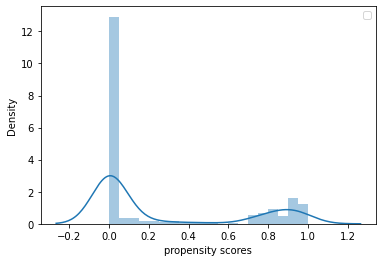

<Figure size 720x360 with 0 Axes>

In [16]:
propensity_scores = clf.predict_proba(X)[:,1] # TODO : insert your estimated propensity scores as np.array
sns.distplot(propensity_scores, bins = num_bins)
plt.legend()
plt.xlabel('propensity scores')
plt.figure(figsize=(10,5))

#### Validation on the overlap assumption :

From the plot, propensity sores are mostly between 0.2 and 0.45, and no propensity score are 0 or 1. Thus, overlap assumption is met.

Now, we are going to use the propensity re-weighting method to estimate average treatment effect (ATE), $\hat{\theta}$. Instead of using the formula we provided above, we're going to make a slgiht change as follows:

\begin{align}
\hat{\theta} = \frac{\sum_{i ~\text{s.t.}~ t_i = 1}y_i \hat{w}_i }{\sum_{i ~\text{s.t.}~ t_i = 1}\hat{w}_i} - \frac{\sum_{i ~\text{s.t.}~ t_i = 0}y_i \hat{w}_i}{\sum_{i ~\text{s.t.}~ t_i = 0} \hat{w}_i},
\end{align} 

where $\hat{w_i} = \frac{\mathbb{1}(t_i = 1)}{\hat{P}(T = 1|X = x_i)} + \frac{1 - \mathbb{1}(t_i = 1)}{\hat{P}(T = 0|X = x_i)}$.

This estimator is known as Hajek estimator, and in practice it is preferred because the obtained estimate is guaranteed to lie between 0 and 1 for a binary outcome $Y$. 

In [17]:
##############################################################################
#                                                                            #
# Apply propensity re-weighting using the provided formula above and         #
# estimate ATE.                                                              #
#                                                                            #
##############################################################################

q3df = nhefs.copy()
q3df['ps'] = propensity_scores
n1 = q3df.iloc[np.where(q3df[treatment_col] == 1)[0]]
n0 = q3df.iloc[np.where(q3df[treatment_col] == 0)[0]]
n1['ps'] = 1/ n1['ps']
n0['ps'] = 1/ n0['ps']

In [18]:
s1 = 0
for idx,row in n1.iterrows():
  s1 += row[outcome_col] /row['ps']
s1 = s1/sum(n1.ps)

In [19]:
s0 = 0
for idx,row in n0.iterrows():
  s0 += row[outcome_col] /row['ps']
s0 = s0/sum(n0.ps)

In [20]:
s1-s0

wt82_71    3.542999
dtype: float64

### Covariate Adjustment

As we learned in class, covariate adjustment is another popular strategy where one explictly models the relationships between the outcome $Y$, treatment $T$ and a set of confounders $X$. With the ignorability and overlap assumptions met, a correctly specified model provides an unbiased estimate of the average treatment effect (ATE). In this section, I will use sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model to obtain 
\begin{align}
  \hat{E}[Y|T = t, X = x].
\end{align}

As we learned in class, when the identifiability assumptions are met, we can relate the data to the potential outcomes. Namely, $\hat{E}[Y(t)|X = x] = \hat{E}[Y|T = t, X = x]$. Therefore, we have
\begin{align}
  \hat{\text{CATE}} &= \hat{E}[Y(1)|X = x] - \hat{E}[Y(0)|X = x] \\
  &= \hat{E}[Y|T = 1, X = x] - \hat{E}[Y|T = 0, X = x] \\
\end{align}
Then, $\hat{\text{ATE}}$ is
\begin{align}
   \hat{\theta} &= \hat{E}_{x \sim p(x)}[\hat{\text{CATE}}] \\
  &= \frac{1}{N} \sum_{i}^N \hat{E}[Y|T = 1, X = x_i] - \hat{E}[Y|T = 0, X = x_i], 
\end{align} where $N$ is the total number of samples. Note that, in the linear model, the coefficient for the treatment variable $T$ corresponds to $\hat{\theta}$ (can you see why?).

In [21]:
## TODO: Task #4 #############################################################
#                                                                            #
# Use covariate adjustment and estimate the ATE.                             #
# Use sklearn's LinearRegression package with default hyperparameter         #
# selection                                                                  #
#                                                                            #
##############################################################################

from sklearn.linear_model import LinearRegression

X = nhefs.drop(outcome_col + ['seqn','wt71','wt82'],axis = 1).dropna(axis='columns')
y = nhefs[outcome_col]
reg = LinearRegression()
reg.fit(X,y)

LinearRegression()

In [23]:
coe_ate = reg.coef_.ravel()[X.columns.isin(treatment_col).ravel()]

In [24]:
coe_ate

array([3.22248425])

#### Comparision bwtween propensity score re-weighting method and covariate adjustment methods:


The mean difference is 2.541 kg without confounders adjustment. After confounders adjustment with propensity score re-weighting and covariate adjustment, the mean difference is 3.543 kg or 3.222 kg. Such difference implies that without proper adjustment on confounders will likely lead to bias in our results.


Please note that out model for the covariate adjustment task (i.e. linear regression)  may be not valid. The model requires the relationshio between all features and Y and linearly related, but some of the feature, such as age is likely to have a non-linear relationship with outcome variable. Without satisfying the necessary condition, the results would be biased.

## Sensitivity Analysis

For our analysis so far, we have assumed the ignorability condition (i.e. $(Y(0), Y(1)) \perp \! \!\! \! \perp T | X$). This also means that there is no unobserved confounding. However, the ignorability condition is untestable, and in observational studies, there could be unobserved confounders which may bias our causal estimate. In this section, we'll assume that there is a single unobserved confounder $U$ as shown in the figure below :


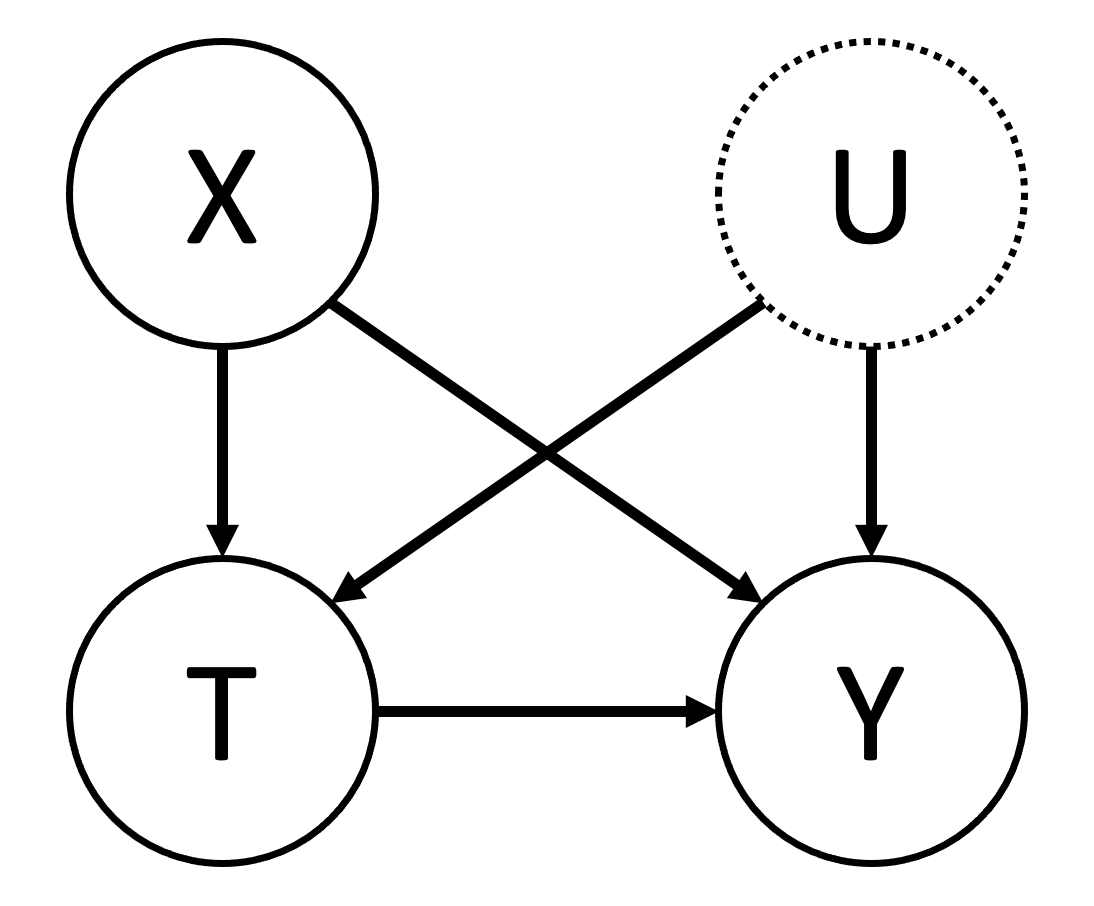

Now suppose that our data are generated by the following process:

\begin{align}
  T &= \alpha_X X + \alpha_U U \\
  Y &= \beta_X X + \beta_U U + \theta T
\end{align}

If we adjust for both measured and unmeasured confounders (i.e. $X$ and $U$), we obtain the unbiased estimate of ATE:

\begin{align}
  E[Y(1) - Y(0)] = E_{X, U}[E[Y|T = 1, X, U] - E[Y|T = 0, X, U]] = \theta
\end{align}

However, $U$ is not measured, so we can only adjust for $X$. It can be mathematically shown that the bias is 

\begin{align}
  E_{X}[E[Y|T = 1, X] - E[Y|T = 0, X]] - \theta = \frac{\beta_U}{\alpha_U}
\end{align}



Now that we know the closed-form expression for the bias, we can derive the true effect size $\theta$ and reason how robust our estimated ATE (i.e. $\hat{\theta}$) is against the unobserved confouding, $U$. In this task, you will generate several contours of $\theta$ where each $\theta$ is represented with respect to $\hat{\theta}$. For this analysis, I use $\hat{\theta}$ from the covariate adjustment method where we assumed no unobserved confounding.

For true treatment effect $\theta$, I choose $\hat{\theta}$ - 1, $\hat{\theta}$ - 2, 0, and -$\hat{\theta}$. I have $\frac{1}{\alpha_U}$ on the x-axis and $\beta_U$ on the y-axis, and each contour plot indicates possible values of $\frac{1}{\alpha_U}$ and $\beta_U$ for a given value of $\theta$. Again, note that in the provided scenario, $\theta$ is a function of the ATE estimated with measured confounders and effect sizes of unmeasured confounders (i.e. $\theta = \hat{\theta} - \frac{\beta_U}{\alpha_U}$).

In [25]:
#############################################################################
#                                                                            #
# Generate the sensitivity analysis plot which contains several contours     #
# of \theta                                                                  #
#                                                                            #
##############################################################################


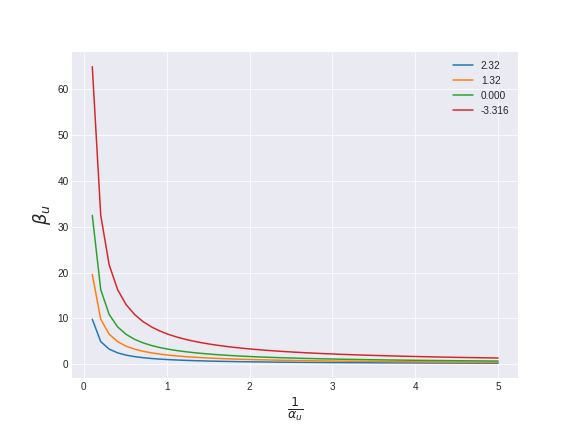

#### Analysis on the unobserved confounding and the robustness of the causal estimate from the observed data: 

In our scenario where we're interested in estimating causal effect of quitting smoking on the weight gain, there may be some unobserved confounders. One potential unobserved confounders could be family house income/economical status. People who are poor are more likely to quit smoke as they do not have enough money to buy tobacco. On the other hand, frequent consumption of junk food due to poverty can also lead to weight gain.
Another example of unmeasured confounder is pressure level. For most people, smoking is a relax and it's hard for them to quit if the pressure level is high. Also, having a high pressure could lead to weight loss as people usually have pay little attention to their food if they are pressued by something else.



Based on the plot, the green curve(the contour plot for $\theta = 0$) indicates how strong the confounding needs to be in order to completely explain the observed association. As strength of unobserved confounding increases, (i.e., 1 αμ,βμ) would need to be large enough to be on the green curve or above in order to have the true ATE be 0 or the opposite sign. Note that $\theta = 0$ indicates the boundary at which the true ATE will give the opposite sign as we estimate.